## Behavioral Cloning

The goals / steps of this project are the following:

* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

### 1. Loading Data

In [166]:
# Imports

import csv
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn


# Loading the images

lines = []

with open('./data/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

with open('./simulatordata/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

print('loaded file')

image_paths = []
angles = []

for line in lines[1:]:
 
    center_current_path = './data/data/IMG/' + line[0].split('/')[-1]
    left_current_path = './data/data/IMG/' + line[1].split('/')[-1]
    right_current_path = './data/data/IMG/' + line[2].split('/')[-1]
    
    # Loading the center, left and right images with steering angles modified by 0.2 for left and right images
    
    if float(line[3]) != 0:
        image_paths.extend((center_current_path, left_current_path, right_current_path))  
        angles.extend((float(line[3]), float(line[3]) + 0.2, float(line[3]) - 0.2))
    else:
        image_paths.append(center_current_path)  
        angles.append(float(line[3]))
               
print("Number of samples =", len(angles))

loaded file
Number of samples = 18131


In [167]:
print(keras.__version__)

2.1.5


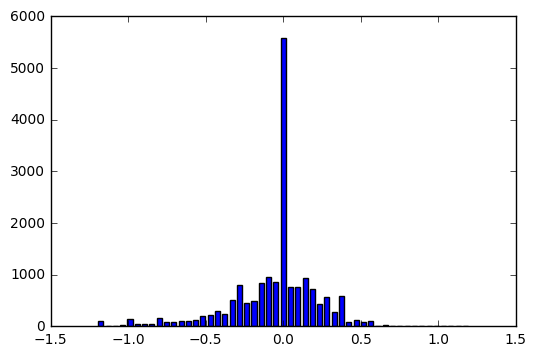

In [168]:
# Histogram of the available steering angles in the dataset

hist, bins = np.histogram(angles, bins=51)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist,align='center', width=width)
plt.show()

In [169]:
# converting to numpy arrays 
image_paths = np.asarray(image_paths)
angles = np.asarray(angles)

### 2. Data Set Adjustment 

In [170]:
#randomly removing images with zero angles from the dataset
zero_inds = np.where(angles == 0)[0]
shuffle(zero_inds)

remove_inds = zero_inds[:int(0.6*len(zero_inds))]
image_paths = np.delete(image_paths, remove_inds)
angles = np.delete(angles, remove_inds)

print("Number of samples =", len(angles))

Number of samples = 15268


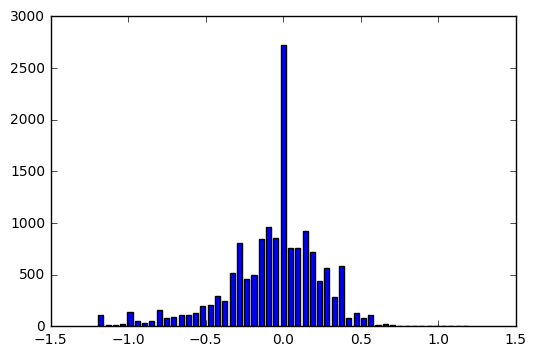

In [171]:
# Histogram of the available steering angles in the dataset

hist, bins = np.histogram(angles, bins=51)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist,align='center', width=width)
plt.show()

### 3. Visualizing the images

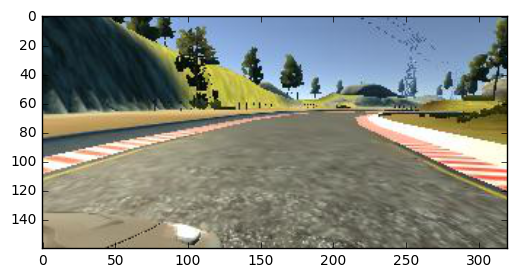

In [172]:
# Normal Image
random = np.random.randint(0, len(image_paths))
img = mpimg.imread(image_paths[random])    

fig = plt.figure()
plt.imshow(img)
plt.show()
fig.savefig("./output_images/normal_image.png")

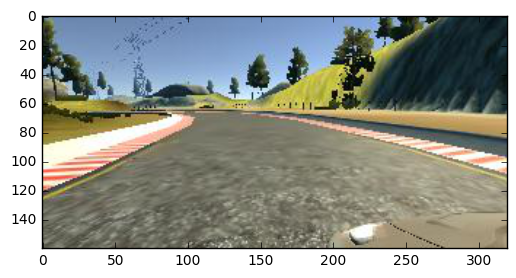

In [173]:
# Flipped Image
flipped = flipimg(img)

fig = plt.figure()
plt.imshow(flipped)
plt.show()
fig.savefig("./output_images/flipped_image.png")

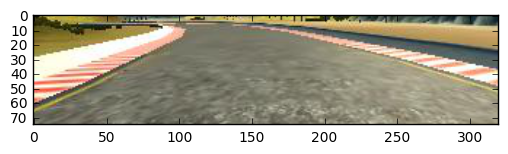

In [174]:
# Cropped Image

cropped = flipped[60:-25, :, :]

fig = plt.figure()
plt.imshow(cropped)
plt.show()
fig.savefig("./output_images/cropped_image.png")

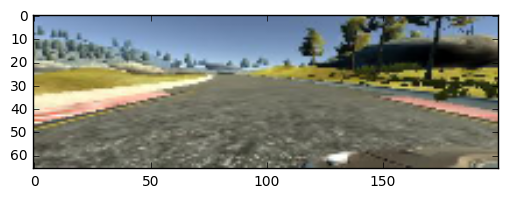

In [175]:
# resized image

resized = cv2.resize(image, (200, 66), cv2.INTER_AREA)

fig = plt.figure()
plt.imshow(resized)
plt.show()
fig.savefig("./output_images/resized_image.png")

### 4. Generator 

In [176]:
# Shuffle the image and angle arrays
image_paths, angles = shuffle(image_paths, angles)

In [183]:
def generator(image_paths, angles, batch_size=128):
    
    X,y = ([],[])
    image_paths, angles = shuffle(image_paths, angles)
    while True:       
        for i in range(len(angles)):
            
            try:
                image = mpimg.imread(image_paths[i])
            except:
                continue
            X.append(image)
            y.append(angles[i])
            if len(X) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                image_paths, angles = shuffle(image_paths, angles)
                
            if abs(angles[i]) > 0.3:
                X.append(flipimg(image))
                y.append(-angles[i])
                
            if len(X) == batch_size:   
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                image_paths, angles = shuffle(image_paths, angles)

In [184]:
# spitting the data into training and validation data with shuffling

images_training, images_validation, angles_training, angles_validation = train_test_split(image_paths, angles,
                                                                                  test_size=0.2)

train_generator = generator(images_training, angles_training, batch_size=128)

validation_generator = generator(images_validation, angles_validation, batch_size=128)

### 5. Builing Model

In [185]:
from keras.layers.core import K
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Reshape
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization

# Nvidia model

def getNvidiaModel():

    keep_prob = 0.5
    keep_prob_dense = 0.7
    
    model = Sequential()

    model.add(Cropping2D(cropping=((60,25), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
    model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization

    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding="valid",activation='relu', kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(36,(5, 5), strides=(2, 2), padding="valid", activation='relu', kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(48,(5, 5), strides=(2, 2), padding="valid", activation='relu', kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Flatten())
    model.add(Dense(100, kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob_dense))
    model.add(Dense(50, kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob_dense))
    model.add(Dense(10, kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob_dense))
    model.add(Dense(1, kernel_initializer="glorot_normal"))

    return(model)


### 6. Training the Model

In [186]:
model = getNvidiaModel()

model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator=train_generator, steps_per_epoch=len(images_training) // 128,
                    validation_steps=len(images_validation) // 128, epochs=10, verbose=1, 
                    validation_data=validation_generator)

model.save('model2.h5')

Epoch 1/10
95/95 [==============================] - 73s 767ms/step - loss: 0.0739 - val_loss: 0.0631